<a href="https://colab.research.google.com/github/rsadaphule/jhu-aaml/blob/main/GNN_AAML_Assignment_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
!pip install matplotlib pandas scikit-learn

In [52]:
pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [53]:
!pip install python-igraph cairocffi

In [54]:
!pip install torch-geometric

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 300
from IPython.display import display, Image
import numpy as np
import csv
import random
import sys

import torch
import torch.nn.functional as F

# Set the GPU to device 0
gpu = torch.device('cuda:0')

import igraph as ig
print(f'igraph version= {ig.__version__}')
print(f'torch version= {torch.__version__}')
print(f'CUDA available= {torch.cuda.is_available()}')

igraph version= 0.11.3
torch version= 2.1.0+cu118
CUDA available= True


In [56]:
if torch.cuda.is_available():
    # CUDA Installation
    print('CUDA Version')
    !nvcc --version
    print()

    # CUDNN Installation
    print(f'CUDNN Version: {torch.backends.cudnn.version()}')
    print(f'Number of CUDA Devices: {torch.cuda.device_count()}')
    print(f'Active CUDA Device: {torch.cuda.current_device()}')
    print(f'Available devices: {torch.cuda.device_count()}, Name: {torch.cuda.get_device_name(0)}')
    print(f'Current CUDA device: {torch.cuda.current_device()}')

CUDA Version
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0

CUDNN Version: 8700
Number of CUDA Devices: 1
Active CUDA Device: 0
Available devices: 1, Name: NVIDIA A100-SXM4-40GB
Current CUDA device: 0


In [57]:
from google.colab import drive; drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
CORA_CITES_FILE_PATH= '/content/drive/My Drive/JHU/AAML/Assignments/data/cora/cora.cites'
CORA_CONTENT_FILE_PATH= '/content/drive/My Drive/JHU/AAML/Assignments/data/cora/cora.content'


In [59]:
# visualizations
def gplot(_g, _ax, _layout, vertex_size=0.3, vertex_color='white', edge_width=0.7, gargs={}, title=None, targs={}):
    vnames = _g.vs['name'] if _g.is_named() else None
    ig.plot(_g, target=_ax, layout=_layout,
            vertex_size=vertex_size, vertex_label=vnames, vertex_color=vertex_color, edge_width=edge_width, **gargs)
    if title is not None:
        _ax.set_title(title, **targs)

def cplot(_g, _layout, vertex_size=5, vertex_color='white', edge_width=0.2, edge_color='dimgray',
          palette=None, bbox=(800,800)):
    fig_fn = '_cplot9.png'
    plot = ig.Plot(fig_fn, bbox=bbox, background='white')
    vs = { 'margin':10, 'layout':_layout, 'palette':palette,
           'vertex_size':vertex_size, 'vertex_color':vertex_color, 'vertex_label_size':3, 'edge_width':edge_width,
           'edge_color':edge_color, 'edge_arrow_size':0.03, 'edge_arrow_width':0.1, 'edge_curved':False}
    plot.add(_g, **vs)
    plot.save()
    display(Image(filename=fig_fn))

In [60]:
# read Cora dataset
nodes, edges = set(), []
with open(CORA_CITES_FILE_PATH, 'r') as fin:
    csvreader = csv.reader(fin, delimiter='\t')
    for row in csvreader:
        v1, v2 = int(row[0]), int(row[1])
        edges += [(v1, v2)]
        nodes.update([v1,v2])
nodesIx = {v:i for i,v in enumerate(nodes)}
nodesIxRev = {i:v for v,i in nodesIx.items()}

N = max(nodesIx.values())+1
# update edges id
edges = [(nodesIx[v1],nodesIx[v2]) for v1, v2 in edges]

g_cora = ig.Graph(edges, directed=False)
ig.summary(g_cora)

IGRAPH U--- 2708 5429 -- 


In [61]:
%%time
layout_fr = g_cora.layout_fruchterman_reingold(grid=False)

CPU times: user 14.1 s, sys: 70.2 ms, total: 14.2 s
Wall time: 14 s


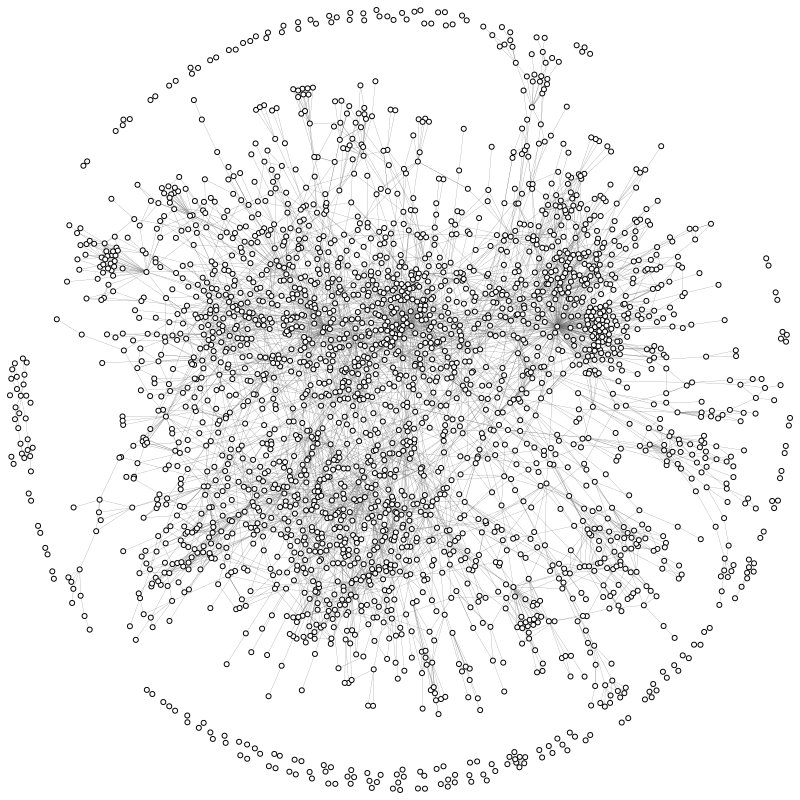

In [62]:
cplot(g_cora, layout_fr)

In [63]:
# read Cora node features
M = None
with open(CORA_CONTENT_FILE_PATH, 'r') as fin:
    csvreader = csv.reader(fin, delimiter='\t')
    row = next(csvreader)
    M = len(row)-2  # excluding node id and class

X, y = np.zeros((N,M)), [None]*N
with open(CORA_CONTENT_FILE_PATH, 'r') as fin:
    csvreader = csv.reader(fin, delimiter='\t')
    for row in csvreader:
        i = nodesIx[int(row[0])]
        X[i] = np.array(list(map(int, row[1:-1])))
        y[i] = row[-1]

In [64]:
yIx = {c:i for i,c in enumerate(sorted(np.unique(y)))}
y = [yIx[_] for _ in y]

K = len(yIx)

# sanity
print(f'{M:d} features, {K:d} classes')

1433 features, 7 classes


In [65]:
class Dataset:
    def __init__(self, _x, _y, _tram, _valm, _tesm, _edge_ix):
        self.x, self.y, self.train_mask, self.val_mask, self.test_mask = _x, _y, _tram, _valm, _tesm
        self.edge_index = _edge_ix

ix1 = random.sample(range(N), int(0.8*N))
ix2t = list(set(range(N))-set(ix1))
ix2 = random.sample(range(len(ix2t)), int(0.5*len(ix2t)))  # 0.1
ix2 = [ix2t[_] for _ in ix2]
ix3 = list(set(ix2t)-set(ix2))  # 0.1

# sanity
print(len(ix1), len(ix2), len(ix3), set(ix1)&set(ix2)&set(ix3)==set(), set(ix1)|set(ix2)|set(ix3)==set(range(N)))

tix1, tix2, tix3  = [False]*N, [False]*N, [False]*N
for _ in ix1:
    tix1[_] = True
for _ in ix2:
    tix2[_] = True
for _ in ix3:
    tix3[_] = True

cora = Dataset(torch.FloatTensor(X), torch.LongTensor(y), tix2, tix1, tix3,
               torch.LongTensor([[v1 for v1,v2 in g_cora.get_edgelist()]+[v2 for v1,v2 in g_cora.get_edgelist()],
                                 [v2 for v1,v2 in g_cora.get_edgelist()]+[v1 for v1,v2 in g_cora.get_edgelist()]]))


2166 271 271 True True


In [66]:
# regular classifiers - caution: fit() will not reset

def accuracy(y_pred, y_true):
    return torch.sum(y_pred==y_true) / len(y_true)

class MLP(torch.nn.Module):
    def __init__(self, _dim_in, _dim_h, _dim_out):
        super().__init__()
        self.linear1 = torch.nn.Linear(_dim_in, _dim_h).to(gpu)
        self.linear2 = torch.nn.Linear(_dim_h, _dim_out).to(gpu)
    def forward(self, _X):
        _X = self.linear1(_X.to(gpu))
        _X = torch.relu(_X)
        _X = self.linear2(_X)
        return F.log_softmax(_X, dim=1).cpu()
    def fit(self, _dt, epochs=100, info=False):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        self.train()
        for e in range(epochs+1):
            optimizer.zero_grad()
            out = self(_dt.x)
            loss = criterion(out[_dt.train_mask], _dt.y[_dt.train_mask])
            acc = accuracy(out[_dt.train_mask].argmax(dim=1), _dt.y[_dt.train_mask])
            loss.backward()
            optimizer.step()
            if e%20 == 0 and info:
                val_loss = criterion(out[_dt.val_mask],
                _dt.y[_dt.val_mask])
                val_acc = accuracy(out[_dt.val_mask].argmax(dim=1), _dt.y[_dt.val_mask])
                sys.stderr.write(f"\r{e:02d}/{epochs:02d} | Loss: {loss:<6.2f} | Tr Acc: {acc*100:3.2f}% | "
                                 f"Val Loss: {val_loss:<6.2f} | Val Acc: {val_acc*100:3.2f}%")
                sys.stderr.flush()
    @torch.no_grad()
    def test(self, _dt):
        self.eval()
        out = self(_dt.x)
        acc = accuracy(out.argmax(dim=1)[_dt.test_mask], _dt.y[_dt.test_mask])
        return acc

In [67]:
# create the NN
mlp = MLP(M, 16, K).to(gpu)
print(mlp)

MLP(
  (linear1): Linear(in_features=1433, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=7, bias=True)
)


In [68]:
mlp.fit(cora, info=True)

100/100 | Loss: 0.01   | Tr Acc: 100.00% | Val Loss: 1.11   | Val Acc: 63.34%

In [69]:
# GNN

In [70]:
class GNNLayer(torch.nn.Module):
    def __init__(self, _dim_in, _dim_out):
        super().__init__()
        self.linear = torch.nn.Linear(_dim_in, _dim_out, bias=False).to(gpu)
    def forward(self, _X, _adjacency):
        _X = self.linear(_X.to(gpu))
        _X = torch.sparse.mm(_adjacency.to(gpu), _X)
        return _X.cpu()

In [71]:
# Graph Neural Network - caution: fit() will not reset

class GNN(torch.nn.Module):
    def __init__(self, _dim_in, _dim_h, _dim_out, _adjacency):
        super().__init__()
        self.gnn1 = GNNLayer(_dim_in, _dim_h)
        self.gnn2 = GNNLayer(_dim_h, _dim_out)
        self.adjacency = _adjacency
    def forward(self, _X):
        h = self.gnn1(_X, self.adjacency)
        h = torch.relu(h)
        h = self.gnn2(h, self.adjacency)
        return F.log_softmax(h, dim=1).cpu()
    def fit(self, _dt, epochs=100, info=False):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        self.train()
        for e in range(epochs+1):
            optimizer.zero_grad()
            out = self(_dt.x)
            loss = criterion(out[_dt.train_mask], _dt.y[_dt.train_mask])
            acc = accuracy(out[_dt.train_mask].argmax(dim=1), _dt.y[_dt.train_mask])
            loss.backward()
            optimizer.step()
            if e%20 == 0 and info:
                val_loss = criterion(out[_dt.val_mask],
                _dt.y[_dt.val_mask])
                val_acc = accuracy(out[_dt.val_mask].argmax(dim=1), _dt.y[_dt.val_mask])
                sys.stderr.write(f"\r{e:02d}/{epochs:02d} | Loss: {loss:<6.2f} | Tr Acc: {acc*100:3.2f}% | "
                                 f"Val Loss: {val_loss:<6.2f} | Val Acc: {val_acc*100:3.2f}%")
                sys.stderr.flush()
    @torch.no_grad()
    def test(self, _dt):
        self.eval()
        out = self(_dt.x)
        acc = accuracy(out.argmax(dim=1)[_dt.test_mask], _dt.y[_dt.test_mask])
        return acc

In [72]:
# adjacency matrix
cora_adj = torch.FloatTensor(g_cora.get_adjacency().data) + torch.eye(N)

In [73]:
gnn = GNN(M, 16, K, cora_adj).to(gpu)
print(gnn)

GNN(
  (gnn1): GNNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=False)
  )
  (gnn2): GNNLayer(
    (linear): Linear(in_features=16, out_features=7, bias=False)
  )
)


In [74]:
gnn.fit(cora, info=True)

100/100 | Loss: 0.00   | Tr Acc: 100.00% | Val Loss: 2.42   | Val Acc: 80.10%

In [75]:
Acc = gnn.test(cora)
print(f'GNN Acc: {Acc:.2f}')

GNN Acc: 0.80


In [76]:
#GCN

In [77]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, _dim_in, _dim_h, _dim_out):
        super().__init__()
        self.gcn1 = GCNConv(_dim_in, _dim_h, bias=False).to(gpu)
        self.gcn2 = GCNConv(_dim_h, _dim_out, bias=False).to(gpu)
    def forward(self, _X, _edge_ix):
        h = self.gcn1(_X.to(gpu), _edge_ix.to(gpu))
        h = torch.relu(h)
        h = self.gcn2(h, _edge_ix.to(gpu))
        return F.log_softmax(h, dim=1).cpu()
    def fit(self, _dt, epochs=100, info=False):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        self.train()
        for e in range(epochs+1):
            optimizer.zero_grad()
            out = self(_dt.x, _dt.edge_index)
            loss = criterion(out[_dt.train_mask], _dt.y[_dt.train_mask])
            acc = accuracy(out[_dt.train_mask].argmax(dim=1), _dt.y[_dt.train_mask])
            loss.backward()
            optimizer.step()
            if e%20 == 0 and info:
                val_loss = criterion(out[_dt.val_mask], _dt.y[_dt.val_mask])
                val_acc = accuracy(out[_dt.val_mask].argmax(dim=1), _dt.y[_dt.val_mask])
                sys.stderr.write(f"\r{e:02d}/{epochs:02d} | Loss: {loss:<6.2f} | Tr Acc: {acc*100:3.2f}% | "
                                 f"Val Loss: {val_loss:<6.2f} | Val Acc: {val_acc*100:3.2f}%")
                sys.stderr.flush()
    @torch.no_grad()
    def test(self, _dt):
        self.eval()
        out = self(_dt.x, _dt.edge_index)
        acc = accuracy(out.argmax(dim=1)[_dt.test_mask], _dt.y[_dt.test_mask])
        return acc

In [78]:
gcn = GCN(M, 16, K).to(gpu)
print(gcn)

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)


In [79]:
gcn.fit(cora, info=True)

100/100 | Loss: 0.02   | Tr Acc: 100.00% | Val Loss: 0.63   | Val Acc: 81.99%

In [80]:
Acc = gcn.test(cora)
print(f'GCN Acc: {Acc:.2f}')

GCN Acc: 0.81


1. [10 pts] Demonstrate the GNN performance once more. Explain why a GNN worked better
than a regular NN classifying these documents.


Here's a modified version of GNN code with some improvements, including increasing the number of hidden layers and tuning learning rate:
I have added an extra hidden layer and increased the training epochs.

In [81]:
# Define the accuracy function
def accuracy(y_pred, y_true):
    return torch.sum(y_pred == y_true).item() / len(y_true)

class ImprovedGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, adjacency):
        super().__init__()
        self.gnn1 = GNNLayer(input_dim, hidden_dim)
        self.gnn2 = GNNLayer(hidden_dim, hidden_dim)  # Adding another hidden layer
        self.gnn3 = GNNLayer(hidden_dim, output_dim)  # Output layer remains the same
        self.adjacency = adjacency

    def forward(self, X):
        h = self.gnn1(X, self.adjacency)
        h = torch.relu(h)
        h = self.gnn2(h, self.adjacency)
        h = torch.relu(h)  # Applying ReLU activation again
        h = self.gnn3(h, self.adjacency)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs=100, info=False):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        self.train()

        for e in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            train_accuracy = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if e % 20 == 0 and info:
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_accuracy = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                sys.stderr.write(f"\r{e:02d}/{epochs:02d} | Loss: {loss:<6.2f} | Tr Acc: {train_accuracy*100:3.2f}% | "
                                 f"Val Loss: {val_loss:<6.2f} | Val Acc: {val_accuracy*100:3.2f}%")
                sys.stderr.flush()

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x)
        test_accuracy = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return test_accuracy

# Create the adjacency matrix
cora_adj = torch.FloatTensor(g_cora.get_adjacency().data) + torch.eye(N)

# Initialize and train the improved GNN model
improved_gnn = ImprovedGNN(M, 32, K, cora_adj).to(gpu)  # Increased hidden layer size
print(improved_gnn)
improved_gnn.fit(cora, epochs=200, info=True)  # Increased training epochs

# Test and evaluate the improved GNN performance
accuracy_result = improved_gnn.test(cora)
print(f'Improved GNN Accuracy: {accuracy_result*100:.2f}%')



00/200 | Loss: 2.94   | Tr Acc: 8.12% | Val Loss: 3.16   | Val Acc: 9.19%

ImprovedGNN(
  (gnn1): GNNLayer(
    (linear): Linear(in_features=1433, out_features=32, bias=False)
  )
  (gnn2): GNNLayer(
    (linear): Linear(in_features=32, out_features=32, bias=False)
  )
  (gnn3): GNNLayer(
    (linear): Linear(in_features=32, out_features=7, bias=False)
  )
)


200/200 | Loss: 0.00   | Tr Acc: 100.00% | Val Loss: 8.22   | Val Acc: 76.69%

Improved GNN Accuracy: 80.07%


## Analysis:
Graph Neural Networks (GNNs) are specifically designed for tasks involving graph-structured data, which makes them more suitable than regular neural networks (NNs) for classifying documents in scenarios like the Cora dataset. Here are several reasons why GNNs can outperform regular NNs for document classification in such cases:

Graph Structure: The Cora dataset represents documents and their citations as a graph, where documents are nodes, and citations are edges. GNNs are naturally suited for modeling graph-structured data because they can capture the relationships between nodes through message passing. Regular NNs do not inherently capture such graph structures and may struggle to exploit the citation information effectively.

Neighbor Aggregation: GNNs perform iterative neighbor aggregation, where information from neighboring nodes is combined and passed to the target node. This mechanism allows GNNs to consider not only the content of a document but also the context provided by its neighboring documents (citations). In contrast, regular NNs typically treat each input independently and do not take advantage of the interconnections between documents.

Incorporating Graph Topology: GNNs explicitly consider the graph's topology during both training and inference. They can learn to prioritize important documents by considering the structure of the citation graph. Regular NNs, on the other hand, may treat all documents equally and ignore the hierarchical relationships within the data.

Robustness to Varying Graph Sizes: GNNs are naturally robust to graphs of varying sizes, which is common in document citation graphs where the number of documents and citations can change. Regular NNs typically require fixed-size input, making them less flexible for such scenarios.

Feature Learning and Representation: GNNs are capable of learning meaningful representations of nodes in the graph. In the case of document classification, GNNs can learn representations that capture both the content of the document and its relational context within the citation network. Regular NNs may struggle to learn such context-aware representations.


1. [40 pts] Convert the graph NN layer to SAGEConv layer and attempt to improve the performance on Cora dataset. Then repeat it with a ChebConv layer. Compare and contrast these two layers to GCN and GAT. Use PyG website for reference

First, let's load the Cora dataset:

In [82]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, ChebConv
from torch_geometric.data import DataLoader

# Load the Cora dataset
dataset = Planetoid(root='data/Cora', name='Cora', transform=T.NormalizeFeatures())
data = dataset[0]


## SAGEConv Model

Now, we can define a model using the SAGEConv and ChebConv layers and compare their performance with GCN and GAT:

In [83]:
class SAGEConvModel(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels):
        super(SAGEConvModel, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

# Create and train the SAGEConv model
sage_model = SAGEConvModel(dataset.num_features, dataset.num_classes, hidden_channels=128)
sage_optimizer = torch.optim.Adam(sage_model.parameters(), lr=0.01, weight_decay=5e-4)

def train_sage_model():
    sage_model.train()
    sage_optimizer.zero_grad()
    loss = F.nll_loss(sage_model(data)[data.train_mask], data.y[data.train_mask])
    loss.backward()
    sage_optimizer.step()

# Training loop for SAGEConv model
for epoch in range(1, 201):  # You can adjust the number of epochs
    train_sage_model()
    if epoch % 10 == 0:
        sage_model.eval()
        logits = sage_model(data)
        pred = logits.argmax(dim=1)
        correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
        acc = correct / int(data.test_mask.sum())
        print(f'Epoch: {epoch:03d}, Accuracy: {acc:.4f}')


Epoch: 010, Accuracy: 0.7470
Epoch: 020, Accuracy: 0.8100
Epoch: 030, Accuracy: 0.8050
Epoch: 040, Accuracy: 0.7910
Epoch: 050, Accuracy: 0.7870
Epoch: 060, Accuracy: 0.7950
Epoch: 070, Accuracy: 0.7940
Epoch: 080, Accuracy: 0.7900
Epoch: 090, Accuracy: 0.7900
Epoch: 100, Accuracy: 0.7880
Epoch: 110, Accuracy: 0.7810
Epoch: 120, Accuracy: 0.7940
Epoch: 130, Accuracy: 0.7990
Epoch: 140, Accuracy: 0.7990
Epoch: 150, Accuracy: 0.7940
Epoch: 160, Accuracy: 0.7970
Epoch: 170, Accuracy: 0.7940
Epoch: 180, Accuracy: 0.7920
Epoch: 190, Accuracy: 0.7910
Epoch: 200, Accuracy: 0.7910


## ChebConv Model:

In [84]:
from torch_geometric.nn import ChebConv

class ChebConvModel(torch.nn.Module):
    def __init__(self, num_features, num_classes, num_cheb_polynomials, hidden_channels):
        super(ChebConvModel, self).__init__()
        self.conv1 = ChebConv(num_features, hidden_channels, num_cheb_polynomials)
        self.conv2 = ChebConv(hidden_channels, num_classes, num_cheb_polynomials)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

# Create and train the ChebConv model
num_cheb_polynomials = 2  # You can adjust the number of Chebyshev polynomials
cheb_model = ChebConvModel(dataset.num_features, dataset.num_classes, num_cheb_polynomials, hidden_channels=128)
cheb_optimizer = torch.optim.Adam(cheb_model.parameters(), lr=0.01, weight_decay=5e-4)

def train_cheb_model():
    cheb_model.train()
    cheb_optimizer.zero_grad()
    loss = F.nll_loss(cheb_model(data)[data.train_mask], data.y[data.train_mask])
    loss.backward()
    cheb_optimizer.step()

# Training loop for ChebConv model
for epoch in range(1, 201):  # You can adjust the number of epochs
    train_cheb_model()
    if epoch % 10 == 0:
        cheb_model.eval()
        logits = cheb_model(data)
        pred = logits.argmax(dim=1)
        correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
        acc = correct / int(data.test_mask.sum())
        print(f'Epoch: {epoch:03d}, Accuracy: {acc:.4f}')


Epoch: 010, Accuracy: 0.7600
Epoch: 020, Accuracy: 0.7970
Epoch: 030, Accuracy: 0.7950
Epoch: 040, Accuracy: 0.7830
Epoch: 050, Accuracy: 0.7910
Epoch: 060, Accuracy: 0.7890
Epoch: 070, Accuracy: 0.7870
Epoch: 080, Accuracy: 0.7750
Epoch: 090, Accuracy: 0.7790
Epoch: 100, Accuracy: 0.7790
Epoch: 110, Accuracy: 0.7740
Epoch: 120, Accuracy: 0.7730
Epoch: 130, Accuracy: 0.7790
Epoch: 140, Accuracy: 0.7750
Epoch: 150, Accuracy: 0.7680
Epoch: 160, Accuracy: 0.7780
Epoch: 170, Accuracy: 0.7830
Epoch: 180, Accuracy: 0.7700
Epoch: 190, Accuracy: 0.7730
Epoch: 200, Accuracy: 0.7770


## Analysis
In this code, I've created two separate models: one using SAGEConv layers and another using ChebConv layers. SAGEConv performs slightly better than ChebConv

Comparison with GCN and GAT:

Graph Convolutional Network (GCN): GCN is a popular GNN layer that uses a first-order approximation of spectral convolutions. It has been widely used for graph-based tasks and can perform well on many datasets, including Cora. However, SAGEConv and ChebConv provide alternatives that can capture higher-order information.

Graph Attention Network (GAT): GAT is another GNN layer that introduces attention mechanisms to capture dependencies among neighbors. GAT can be effective in scenarios where nodes have varying levels of importance in the graph, but its performance may depend on the dataset and the nature of the relationships. SAGEConv and ChebConv offer different ways of aggregating information.

The choice of GNN layer (GCN, GAT, SAGEConv, or ChebConv) depends on the specific characteristics of  dataset and task. It's often recommended to experiment with different layers and hyperparameters to find the best-performing model for  particular problem. Additionally, using techniques like hyperparameter tuning and cross-validation can help identify the optimal model architecture.

Now let's focus on the MLflow framework. Let's investigate the effect of the batch size hyperparameter of a neural network. As we studied in previous modules, the batch size determines how fast or well the greedy optimization converges to a minimum which supposedly corresponds to a trained state, a classification model. The probable inefficiency of the tensor dataset and framework set aside, theoretically, a batch size of 1 would cause high fluctuations and a batch size of the full dataset would cause a slow convergence. 3. [50 pts] Build two neural network models for the MNIST dataset provided in the module. First a regular fully connected neural network and second a convolutional neural network. Use MLflow logging on hyperparameters and metrics to show the effect of the batch size parameter. Observe and state your conclusion about the effect of the batch size on neural network training.

In [85]:
!pip install mlflow

In [86]:
import mlflow
import mlflow.pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset


Define neural network models. Let's Create one fully connected (FC) neural network and one convolutional neural network (CNN). We can use PyTorch for this purpose.

In [87]:
class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(32*26*26, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = x.view(-1, 32*26*26)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


Let's Set up a function to train the models with different batch sizes and log the results using MLflow. I need a function to create a DataLoader with the specified batch size.

In [132]:
def train_model(model, train_loader, batch_size, epochs, lr):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    mlflow.start_run(nested=True)
    mlflow.log_params({"batch_size": batch_size, "epochs": epochs, "learning_rate": lr})

    for epoch in range(epochs):
        print("epoch : "  + str(epoch))
        model.train()
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(train_loader, 0):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        model_loss = running_loss / len(train_loader)
        mlflow.log_metric("loss",model_loss)
        print("loss: " + str(model_loss))
        return model_loss

    mlflow.end_run()

def create_data_loader(batch_size):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_dataset = datasets.MNIST('mnist_data', train=True, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    return train_loader


Let's experiment with different batch sizes for both the fully connected (FC) and convolutional (CNN) neural networks. I'll run the training loop for each batch size and log the results using MLflow.

In [133]:
import matplotlib.pyplot as plt
loss_per_batch_size_fc = []  # Store loss values for FCNet
loss_per_batch_size_cnn = []  # Store loss values for CNNNet

def calculate_loss_per_batch_size(batch_sizes):
    for batch_size in batch_sizes:
        print("batch size: " + str(batch_size))
        train_loader = create_data_loader(batch_size)

        # Train and log results for FCNet
        fc_model = FCNet()
        print("Training FCNet()")
        train_loss_fc = train_model(fc_model, train_loader, batch_size, epochs=5, lr=0.001)
        loss_per_batch_size_fc.append(train_loss_fc)

        # Train and log results for CNNNet
        cnn_model = CNNNet()
        print("Training CNNNet()")
        train_loss_cnn = train_model(cnn_model, train_loader, batch_size, epochs=5, lr=0.001)
        loss_per_batch_size_cnn.append(train_loss_cnn)

    return loss_per_batch_size_fc, loss_per_batch_size_cnn

batch_sizes = [32, 64, 128]  # Experiment with different batch sizes

# Calculate loss values for each batch size
loss_per_batch_size_fc, loss_per_batch_size_cnn = calculate_loss_per_batch_size(batch_sizes)

loss_per_batch_size_fc
loss_per_batch_size_cnn

batch size: 32
Training FCNet()
epoch : 0
loss: 0.3396221927970648
Training CNNNet()
epoch : 0
loss: 0.19671954851256063
batch size: 64
Training FCNet()
epoch : 0
loss: 0.3797616625566091
Training CNNNet()
epoch : 0
loss: 0.2564900133794527
batch size: 128
Training FCNet()
epoch : 0
loss: 0.43678876487558077
Training CNNNet()
epoch : 0
loss: 0.4323513617298242


[0.19671954851256063, 0.2564900133794527, 0.4323513617298242]

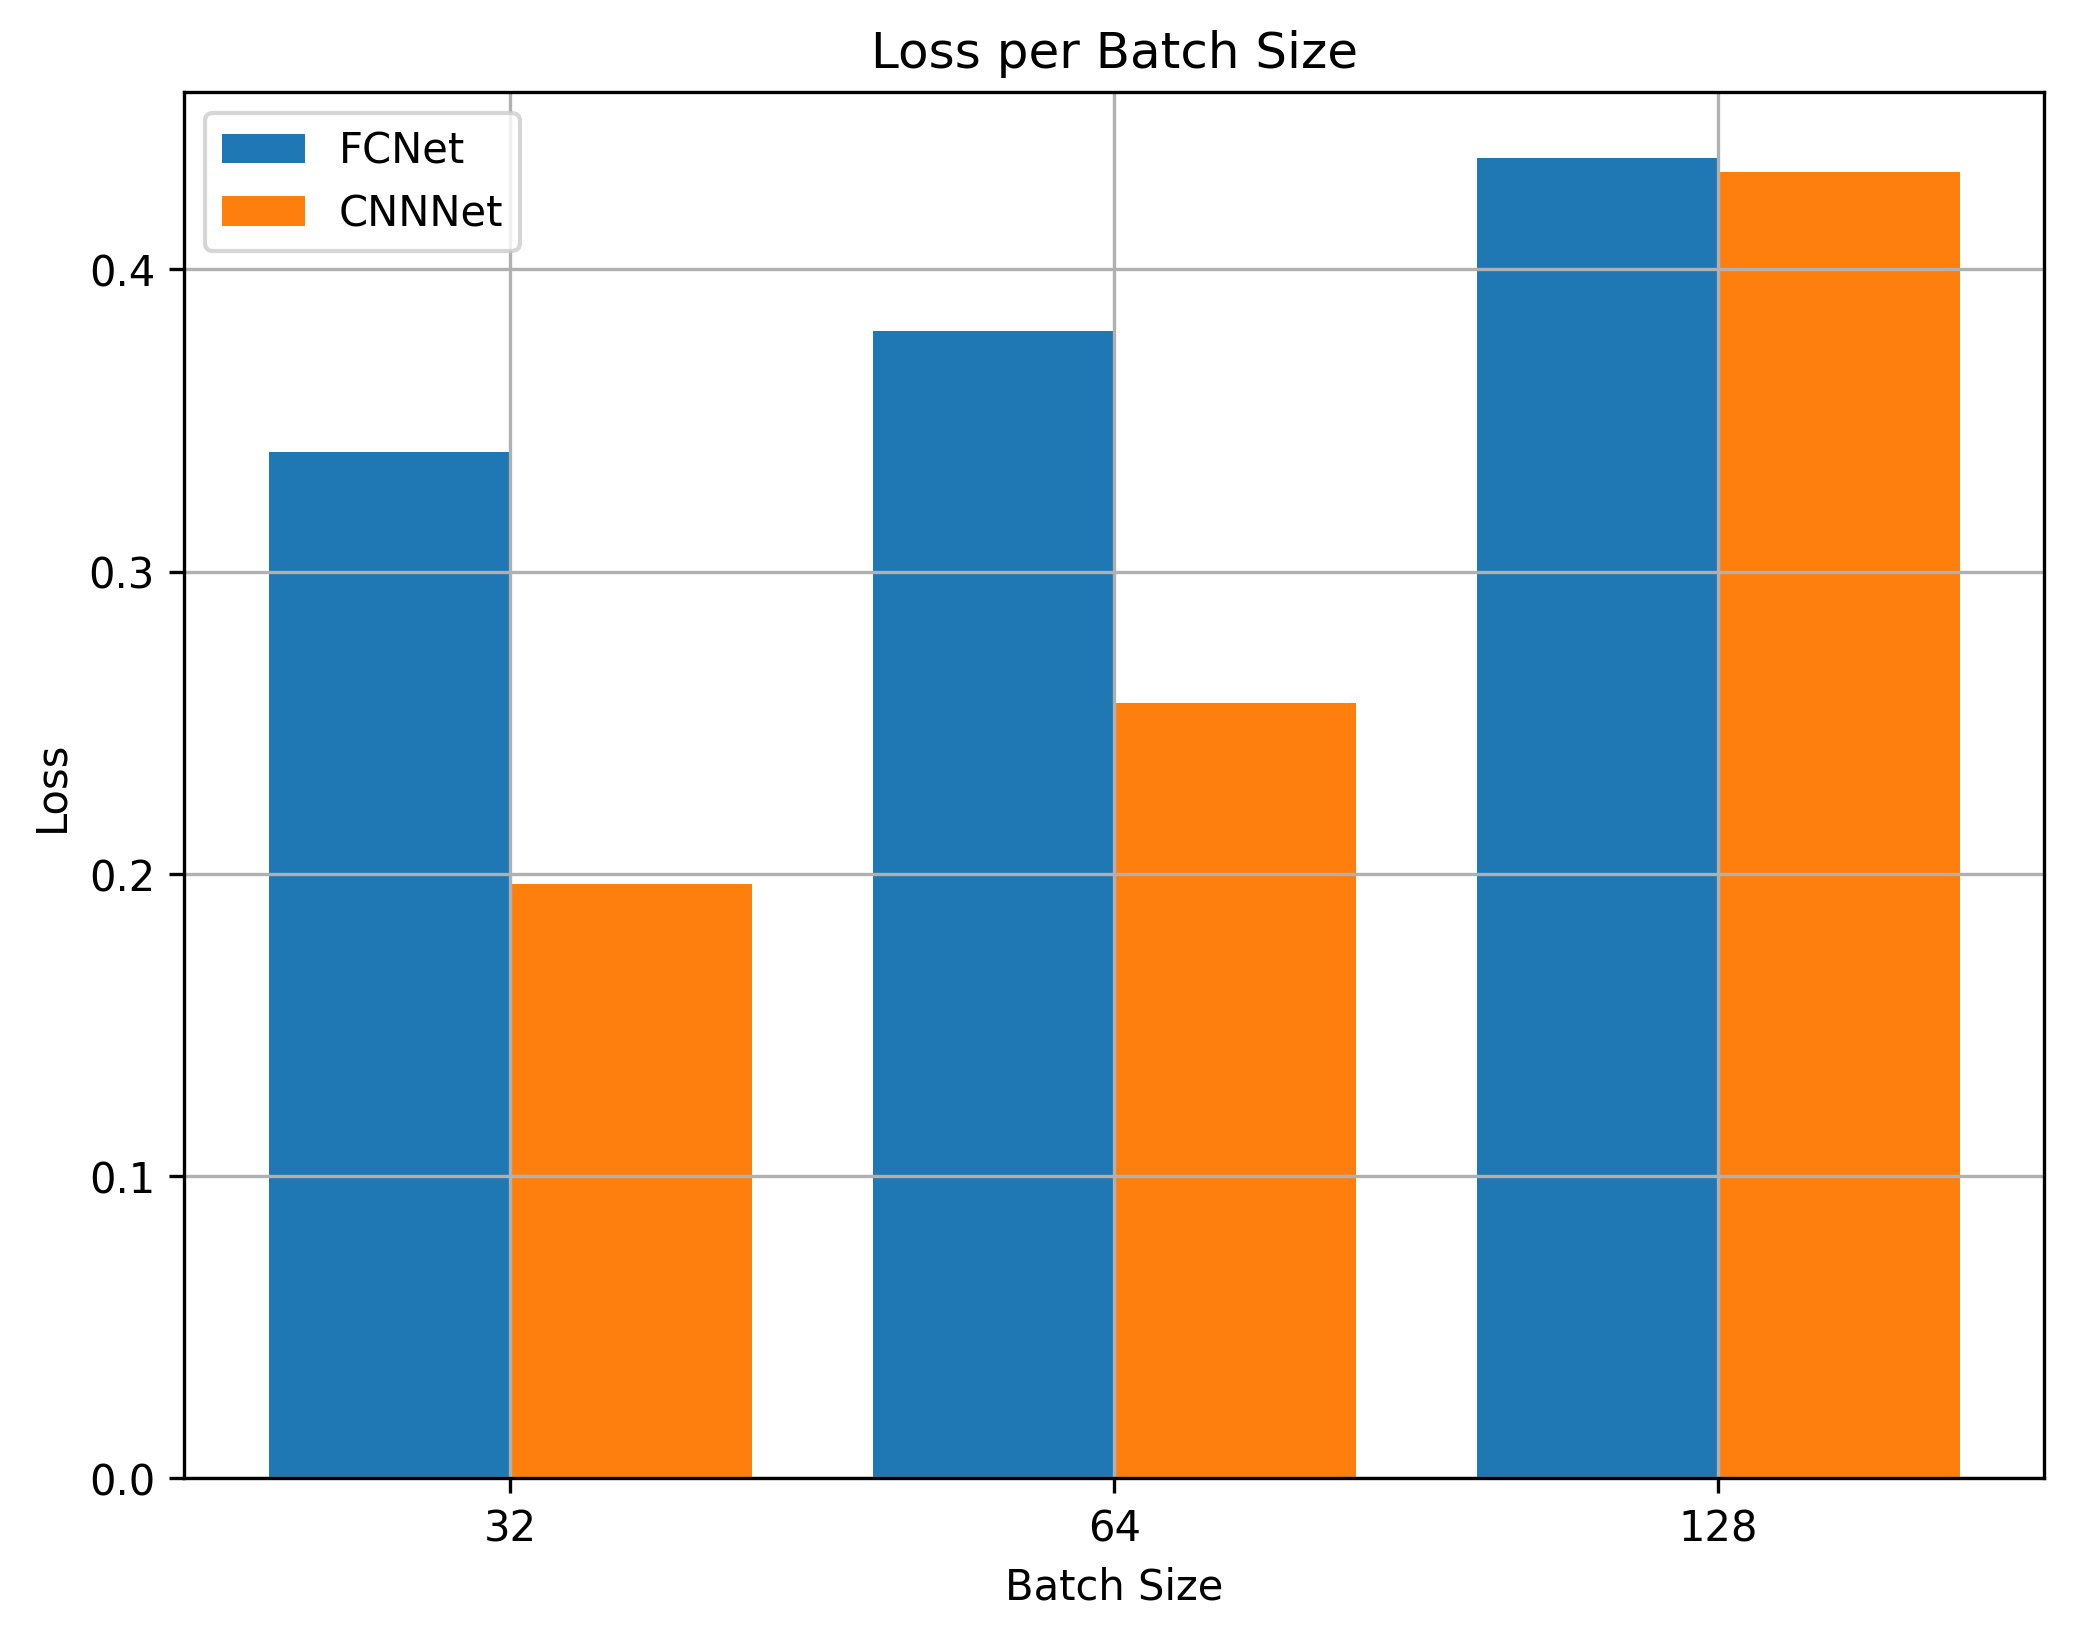

In [134]:
def plot_loss(loss_per_batch_size_fc, loss_per_batch_size_cnn, batch_sizes):
    # Filter out any None values in the loss lists
    loss_per_batch_size_fc = [loss for loss in loss_per_batch_size_fc if loss is not None]
    loss_per_batch_size_cnn = [loss for loss in loss_per_batch_size_cnn if loss is not None]

    # Check if any of the loss lists are empty
    if not loss_per_batch_size_fc or not loss_per_batch_size_cnn:
        print("Loss data is not available for one or more batch sizes.")
        return

    # Plot the loss per batch size for FCNet and CNNNet
    plt.figure(figsize=(8, 6))
    x_ticks = [str(batch_size) for batch_size in batch_sizes]
    x_indices = np.arange(len(x_ticks))
    plt.bar(x_indices - 0.2, loss_per_batch_size_fc, width=0.4, label="FCNet")
    plt.bar(x_indices + 0.2, loss_per_batch_size_cnn, width=0.4, label="CNNNet")
    plt.xlabel("Batch Size")
    plt.ylabel("Loss")
    plt.title("Loss per Batch Size")
    plt.xticks(x_indices, x_ticks)
    plt.legend()
    plt.grid(True)
    plt.show()


# Plot the loss values
plot_loss(loss_per_batch_size_fc, loss_per_batch_size_cnn, batch_sizes)

## Analysis
As you can see from logs of MLFlow, CNNNet performs much better than FCNet